In [1]:
try:
    import rlmep

    print("Already installed")
except ImportError:
    %pip install "rlmep @ git+https://github.com/Mads-PeterVC/rlmep.git" # if you are using Google Colab

Already installed


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from rlmep.exercise_2 import example_figure

%matplotlib inline

# Materials Science RL Environment.

Now that we've developed an RL algorithm it would be cool to apply it to a material's science problem. 

So this exercise will involve the design and implementation of such an environment. 
Specifically, we will try to frame **minimum energy path** (MEP) finding as an 
RL environment. 

This involves the following decisions

- What is the state space?
- What is the action space? 
- What is the reward structure? 

Our Deep Q-learning algorithm can handle continuous state spaces, but only discrete action spaces.

So for this reason we will start with a discrete state and action space. To keep things simple we will limit 
the scope a little (perhaps more than that) and only consider the movement of a single atom. 

I've made an illustration of the kind of environment we will create below.
Here the red dot indicates the starting position and the initial position and the 
green the final position of an atom. Rather than avoiding drowning, we want our RL algorithm 
to learn to avoid taking a path that crosses high-energy regions.

c:\Users\au711232\Documents\rlmep\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


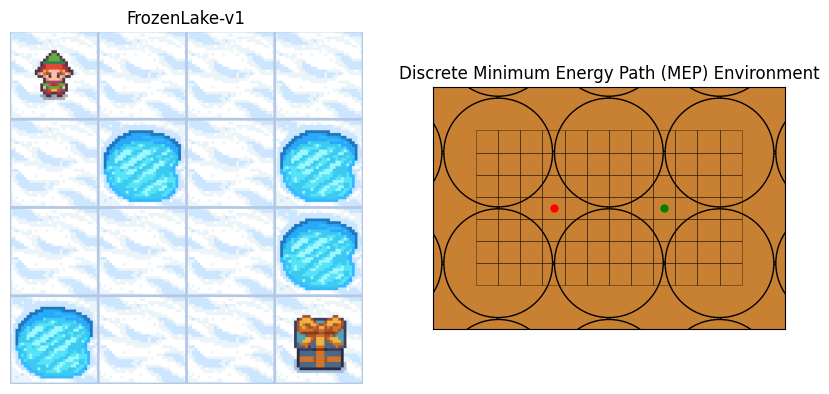

In [3]:
example_figure()

## Implement MEP-environment

### State space

The state-space of our MEP problem will be a 2d-grid. To make handling this grid 
a little easier the `GridSpec`-class provides some methods; 

- `__init__`: Taking the arguments
    - `grid_size` e.g. `(10, 10)`
    - `grid_spacing` e.g. `0.5`
    - `corner` e.g. `(0, 0)`
    - `height` e.g `10.0`.

- `ij_to_xyz`: Takes two arguments `i` and `j` and returns `x`, `y`, `z`.
- `xy_to_ij`: Takes two arguments `x` and `y` and returns `i` and `j`.
- `visualize`: Takes an `Axes`-object and plots the grid.

Convince yourself that these methods work as expected.

In [4]:
from rlmep.exercise_2 import GridSpec

grid_spec = GridSpec(grid_size=(10, 10), grid_spacing=0.5, corner=(0, 0))

grid_spec.ij_to_xyz(1, 1)


(0.5, 0.5, 0.0)

In our environment we will call the position of the moving atom on the grid our `state` which are the 
two indices `(i, j)`.

Our environment also needs to be able to determine when it has reached a terminal or truncated state. 

We will consider two types of terminal states; 

- If the atom has reached the desired final position that is a terminal state. 
- If the atom has reached a state that has an energy higher than a particular threshold above the energy of the initial state.

In the cell below you should implement these two conditions, the function takes four 
inputs 

- `state`: The current state.
- `terminal_state`: The state of the final configuration.
- `history`: The history of the energy of all states visited.
- `delta_max`: The threshold above which to terminate.


In [6]:
def check_terminal(state: list[int, int], terminal_state: list[int, int], history: list[float], delta_max: float) -> bool:
    """
    Check if the state is terminal.
    """
    # Your code here
    terminal = tuple(state) == tuple(terminal_state) or history[-1] - history[0] > delta_max

    return terminal

To avoid the agent going on infinitely looping walks we will truncate an episode if a 
maximum amount of steps have been taken. 

In [7]:
def check_truncated(step: int, max_steps: int) -> bool:
    """
    Check if the episode should be truncated.
    """
    # Your code here
    truncated = step >= max_steps
    return truncated

### Action space

The action space is again a discrete space with four possible values. 

We are mapping (0, 1, 2, 3) to each direction (right, left, up, down) - to conform with the plotting methods 
we want; 

- $ 0 \rightarrow \mathrm{right}$
- $ 1 \rightarrow \mathrm{left}$
- $ 2 \rightarrow \mathrm{up}$
- $ 3 \rightarrow \mathrm{down}$

Complete the function below such when provided an integer it provides the two integers corresponding to a direction on the grid - e.g. 

$ 0 \rightarrow (1, 0)$

In [8]:
def action_to_direction(action: int) -> list[int, int]:
    # Your code here
    if action == 0:
        direction = [1, 0]
    elif action == 1:
        direction = [-1, 0]
    elif action == 2:
        direction = [0, 1]
    elif action == 3:
        direction = [0, -1]
    return direction

When trying to move the atom on the grid we also want to make sure it doesn't move out of bounds. 

So we have to make sure that a move cannot take result in grid coordinates below zero - or grid coordinates above the grid size.

In [ ]:
def update_state(
    state: list[int, int], action: int, grid_size: tuple[int, int]
) -> list[int, int]:
    direction = action_to_direction(action)

    # Your code here
    x = state[0] + direction[0]
    if x < 0:
        x = 0
    if x >= grid_size[0]:
        x = grid_size[0] - 1

    y = state[1] + direction[1]
    if y < 0:
        y = 0
    if y >= grid_size[1]:
        y = grid_size[1] - 1

    return [x, y]

In addition to our integers to represent the state we would also like to manipulate an `ase.Atoms`-object 
based on the state

In [10]:
from ase import Atoms


def update_atoms(
    atoms: Atoms, state: list[int, int], grid_spec: GridSpec, move_index: int
) -> Atoms:
    """
    Update the `ase.Atoms` object based on the state and move index.

    Use the `grid_spec`-object to convert the state to coordinates.
    """
    # Your code here
    position = grid_spec.ij_to_xyz(*state)
    atoms.positions[move_index, :] = position

    return atoms

### Reward

The reward function determines what 'solving' the environment looks like - we need to 
encode our intent into the reward function. 

One choice is to say we record the energy difference at each state visited and 
once the final state is reached we base the reward on this trajectory. 

If we define 

$$
\Delta E_i = E_i - E_{\mathrm{init}}
$$

And we introduce two parameters $\Delta_{max}$ and $A$ we can write a reward for reaching 
the final state 

$$
r = A \left(1 - \frac{\min \ [\max_i \ ( \Delta E_i), \Delta_{max}]}{\Delta_{max}}\right)
$$

Additionally, we can do a bit of reward engineering by at each step rewarding the agent 
if it moves closer to the final state and punishing it if it moves away. One choice 
is 

$$
r = 
\begin{cases}
    r_d, & \text{if } d_i < d_{i-1} \\
    -r_d, & \text{if } d_i > d_{i-1}
\end{cases}
$$

Below `current_distance` is $d_i$, `previous_distance` is $d_{i-1}$ and `distance_parameter` is $r_d$.


In [11]:
def get_final_reward(delta_energies: list[float], A: float, delta_max: float) -> float:
    """
    Calculate the final reward based on the maximum change in energy.
    """
    # Your code here
    barrier = np.min([np.max(delta_energies), delta_max])
    reward = A * (1 - barrier / delta_max)
    return reward

def get_distance_reward(current_distance: float, previous_distance: float, distance_parameter: float) -> float:
    """
    Calculate the reward based on the distance to the target.
    """
    # Your code here
    if current_distance < previous_distance:
        reward = distance_parameter
    elif current_distance > previous_distance:
        reward = -distance_parameter
    else:
        reward = 0.0
    return reward

### Putting it together

I've created a class that takes your function definitions from above and puts it together 
with a few tedious tidbits done for you. 

In [12]:
from rlmep.exercise_2.discrete_mep_scaffold import (
    ScaffoldDiscreteMEP,
)
from rlmep.exercise_2.diffusion_env import get_diffusion_state_grid
from ase.calculators.emt import EMT

functions = {
    "check_terminal": check_terminal,
    "check_truncated": check_truncated,
    "update_state": update_state,
    "update_atoms": update_atoms,
    "get_final_reward": get_final_reward,
    "get_distance_reward": get_distance_reward,
}

intial_config, final_config, grid_spec = get_diffusion_state_grid(
    grid_size=(12, 7),
    grid_spacing=0.5,
    grid_shift=(-3, -3),
)

# You can try this one if you want a finer grid.
# intial_config, final_config, grid_spec = get_diffusion_state_grid(
#     grid_size=(24, 14),
#     grid_spacing=0.25,
#     grid_shift=(-6, -6),
# )

env = ScaffoldDiscreteMEP(
    initial_config=intial_config,
    final_config=final_config,
    gridspec=grid_spec,
    functions=functions,
    moving_atom=-1,
    max_steps=100,
    barrier_max=2.5,
    reward_scale=10.0,
    distance_parameter=0.1,
    calculator=EMT(),
)

### Sanity check

Having assembled the environment we should do a bit of sanity checking that it works as expected. 

In the cell below you can play around with different ways of stepping through the 
environment.

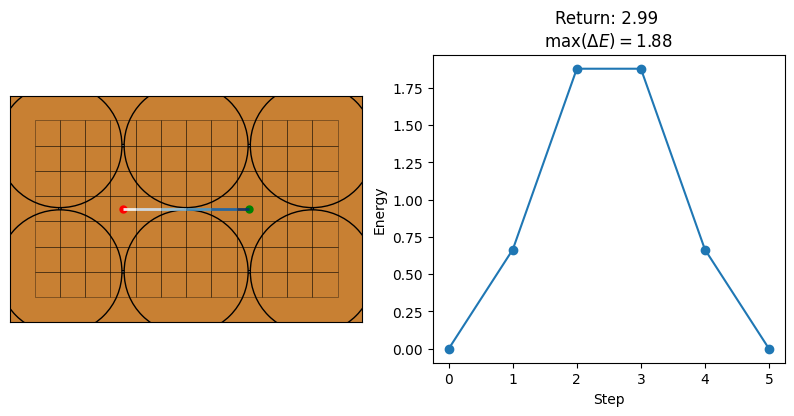

In [23]:
action_trajectory = []  # Use to make a specific action trajectory
state, info = env.reset()
states = [state]

return_value = 0.0

for step in range(50):
    # action = env.action_space.sample()  # Random action
    action = 0  # Always move right
    # action = action_trajectory.pop(0) if action_trajectory else env.action_space.sample()  # Use predefined actions or random

    state, reward, terminal, truncated, info = env.step(action)
    return_value += reward
    states.append(state)

    if terminal or truncated:
        break


fig, ax = plt.subplots(1, 2, figsize=(10, 4))

env.reset()
env.visualize(ax=ax[0], dx=0.5, dy=0.5, plot_moving=False, state_history=states)


ax[1].plot(info["history"], "-o", label="Energy")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Energy")
ax[1].set_title(
    f"Return: {return_value:0.2f} \n" + fr"$\max(\Delta E) = {np.max(info['history']):0.2f}$",
);

Things to check: 

- Set the `reward_scale` to 0.0 to judge if the distance reward works correctly. 
- Does the entire terminate correctly? E.g. terminates if the final state is reached or if a too high energy state is visisted.
- Do the actions do the intended thing? Is the agent able to move in all directions? 

## Test

The cells below import my versions of `Qnet` and of `DQN` - if you want you can also copy your own implementations
from the previous exervise.

In [24]:
from rlmep.exercise_1.dqn_learner import DQN
from rlmep.exercise_1.qnet import Qnet

In [29]:
from rlmep.exercise_1.experience_replay import ExperienceReplay
import torch

env.reset()

# Set the action and observation dimensions:
obs_dim = 2
n_actions = 4

# Set the network settings:
main_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
target_network = Qnet(input_dim=obs_dim, output_dim=n_actions)
replay = ExperienceReplay(observation_dim=obs_dim, size=2000, batch_size=32)

# Make a learner:
learner = DQN(
    main_network,
    target_network,
    replay,
    gamma=0.90,
    train_interval=1,
    copy_interval=100,
    epsilon=lambda i: 0.5
)
num_episodes = 250
returns, lengths = learner.learn(
    env=env,
    num_episodes=num_episodes,
)

return_value, states = learner.rollout(env, episode=0, train=False, apply_epsilon=False)

Output()

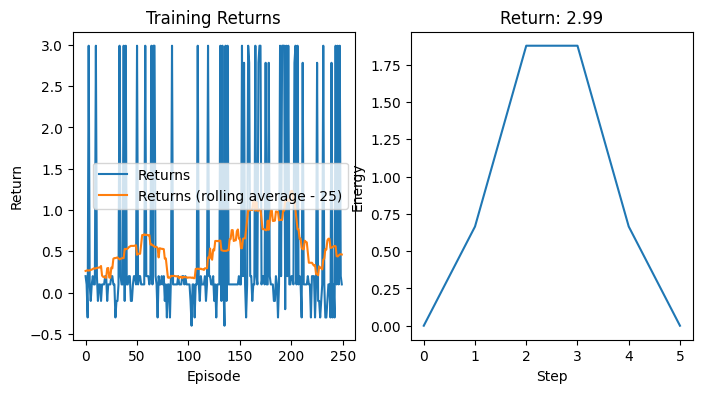

In [31]:
from rlmep.utils.plot_returns import plot_returns

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

plot_returns(ax[0], returns, window=25)

ax[1].plot(env.history)
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Energy")
ax[1].set_title(f"Return: {return_value:0.2f}");

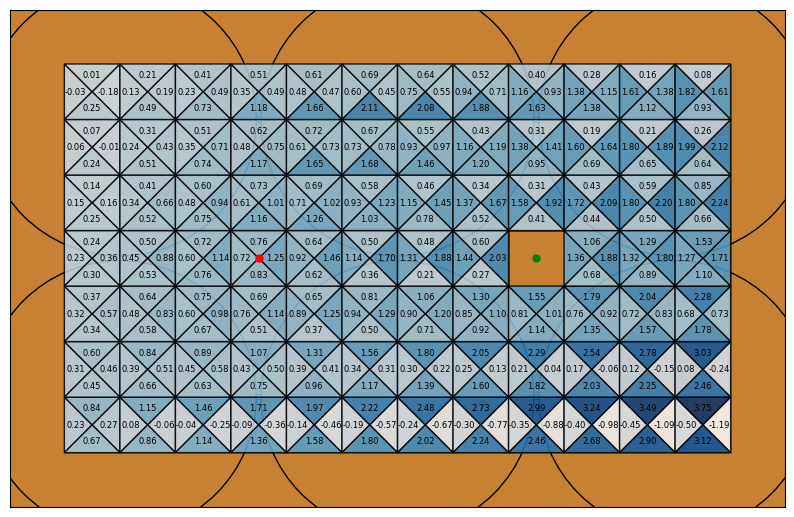

In [32]:
from rlmep.exercise_2 import plot_qvalues

# Calculate the Q-values for each state in the grid:
Q_table_nn = np.zeros((env.gridspec.grid_size[0], env.gridspec.grid_size[1], 4))
for i in range(env.gridspec.grid_size[0]):
    for j in range(env.gridspec.grid_size[1]):
        Q_table_nn[i, j, :] = (
            main_network(torch.tensor([i, j], dtype=torch.float))
            .detach()
            .numpy()
            .flatten()
        )

# Plot the Q-values:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

env.reset()
env.visualize(ax=ax, dx=0.5, dy=0.5, plot_moving=False)
ax = plot_qvalues(ax, Q_table_nn, env, alpha=0.85)